In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import optuna

In [4]:
df = pd.read_csv('0926 예측 값1.csv')

In [5]:
df

,STRG_DT,test_y,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,2022-05-26 19:10:00,0.75,0.969343,398,30.2,0.0,26.9,42.5,20,-0.45
1,2022-05-26 19:20:00,0.75,0.970579,398,30.0,0.0,26.5,45.7,20,-0.45
2,2022-05-26 19:30:00,0.75,0.968785,395,29.5,0.0,26.3,48.0,20,-0.45
3,2022-05-26 19:40:00,0.75,0.972817,399,29.2,0.0,26.1,52.0,20,-0.45
4,2022-05-26 19:50:00,0.75,0.960577,403,29.0,0.0,25.8,55.7,40,-0.45
...,...,...,...,...,...,...,...,...,...,...
5064,2022-06-30 23:10:00,0.50,0.535846,421,25.6,0.0,29.6,91.1,40,-0.75
5065,2022-06-30 23:20:00,0.50,0.530907,421,25.6,0.0,29.6,91.5,40,-0.75
5066,2022-06-30 23:30:00,0.50,0.530782,423,25.7,0.0,29.6,91.8,40,-0.75
5067,2022-06-30 23:40:00,0.50,0.527298,427,25.6,0.0,29.6,92.2,40,-0.75


In [20]:
df.columns

Index(['STRG_DT', 'test_y', 'pred_y', 'PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1',
       'HTNG_TPRT_1', 'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2',
       'SKLT_OPDR_RATE_1_RIGHT', 'GDD'],
      dtype='object')

In [23]:
X = df.iloc[:, 3:]
y = df.iloc[:, 2]

#정규화 진행
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.values.reshape(-1,1))

X_df = pd.DataFrame(X, columns = ['PFBS_NTRO_CBDX_CTRN', 'SPL_TPRT_1','HTNG_TPRT_1', 'SPL_TPRT_2', 'AVE_INNER_HMDT_1_2','SKLT_OPDR_RATE_1_RIGHT', 'GDD'])
y_df = pd.DataFrame(y, columns = ['pred_y'])

# X_df와 y_df를 열 방향으로 합치기
df_normalized = pd.concat([y_df, X_df], axis=1)

In [24]:
df_normalized

,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,1.155163,-0.311797,1.558064,0.0,-0.888543,-2.505011,-0.808194,-0.006939
1,1.159279,-0.311797,1.501642,0.0,-1.003411,-2.272563,-0.808194,-0.006939
2,1.153306,-0.456422,1.360587,0.0,-1.060845,-2.105491,-0.808194,-0.006939
3,1.166732,-0.263589,1.275954,0.0,-1.118279,-1.814931,-0.808194,-0.006939
4,1.125971,-0.070757,1.219532,0.0,-1.204430,-1.546163,-0.012194,-0.006939
...,...,...,...,...,...,...,...,...
5064,-0.288393,0.796988,0.260360,0.0,-0.113185,1.025293,-0.012194,-0.169782
5065,-0.304838,0.796988,0.260360,0.0,-0.113185,1.054349,-0.012194,-0.169782
5066,-0.305254,0.893404,0.288571,0.0,-0.113185,1.076141,-0.012194,-0.169782
5067,-0.316859,1.086236,0.260360,0.0,-0.113185,1.105197,-0.012194,-0.169782


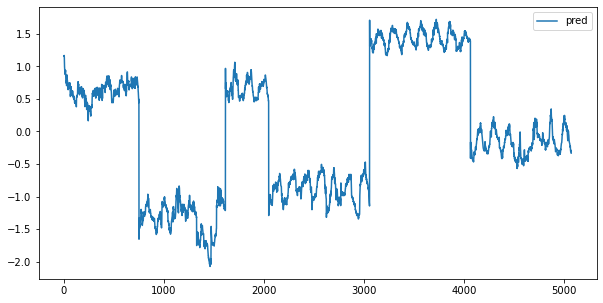

In [7]:
plt.figure(figsize=(10,5))
plt.plot(np.array(y),label = "pred")
plt.legend()
plt.show()

위 그래프를 기준으로 값이 확 바뀌는 부분을 기준으로 데이터셋 나누기

In [36]:
df1 = df_normalized.iloc[:749,:]
df1

,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
0,1.155163,-0.311797,1.558064,0.0,-0.888543,-2.505011,-0.808194,-0.006939
1,1.159279,-0.311797,1.501642,0.0,-1.003411,-2.272563,-0.808194,-0.006939
2,1.153306,-0.456422,1.360587,0.0,-1.060845,-2.105491,-0.808194,-0.006939
3,1.166732,-0.263589,1.275954,0.0,-1.118279,-1.814931,-0.808194,-0.006939
4,1.125971,-0.070757,1.219532,0.0,-1.204430,-1.546163,-0.012194,-0.006939
...,...,...,...,...,...,...,...,...
744,0.561092,0.893404,-1.037344,0.0,-0.256770,0.458701,-0.012194,0.047342
745,0.561993,1.327276,-1.009133,0.0,-0.199336,0.502285,-0.012194,0.047342
746,0.516158,2.146813,-1.065555,0.0,-0.228053,0.582189,-0.012194,0.047342
747,0.455013,2.484270,-1.065555,0.0,-0.170619,0.545869,-0.012194,0.047342


In [27]:
df2 = df_normalized.iloc[749:1613,:]
df2

,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
749,0.493963,1.375484,-1.093766,0.0,-0.170619,0.516813,-0.012194,0.617292
750,-1.655512,1.327276,-1.121977,0.0,-0.170619,0.458701,-0.012194,0.617292
751,-1.332986,1.086236,-1.121977,0.0,-0.113185,0.495021,-0.012194,0.617292
752,-1.440278,1.423692,-1.121977,0.0,-0.084468,0.567661,-0.012194,0.617292
753,-1.458397,1.616525,-1.150188,0.0,0.030400,0.683885,-0.012194,0.617292
...,...,...,...,...,...,...,...,...
1608,-1.144385,-0.552838,-1.178399,0.0,-1.060845,0.320685,-0.410194,0.671573
1609,-1.166538,-0.360005,-1.150188,0.0,-1.003411,0.349741,-0.012194,0.671573
1610,-1.197759,-0.552838,-1.121977,0.0,-1.032128,0.378797,-0.410194,0.671573
1611,-1.172041,-0.311797,-1.150188,0.0,-1.089562,0.465965,-0.410194,0.671573


In [31]:
df3 = df_normalized.iloc[1613:2045,:]
df3

,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
1613,-1.201609,-0.263589,-1.206610,0.0,-1.233147,0.596717,-1.604194,-0.739732
1614,0.968067,-0.456422,-1.234821,0.0,-1.261864,0.596717,-1.604194,-0.739732
1615,0.653596,-0.118965,-1.206610,0.0,-1.261864,0.596717,-1.604194,-0.739732
1616,0.748704,0.314907,-1.206610,0.0,-1.233147,0.633037,-1.604194,-0.739732
1617,0.716103,0.266699,-1.178399,0.0,-1.233147,0.669357,-1.604194,-0.739732
...,...,...,...,...,...,...,...,...
2040,0.528105,0.411323,-0.473125,0.0,-0.371638,1.468397,-0.012194,0.128763
2041,0.516758,0.411323,-0.473125,0.0,-0.371638,1.439341,-0.012194,0.128763
2042,0.497701,0.555948,-0.473125,0.0,-0.400355,1.671789,-0.808194,0.128763
2043,0.470117,0.555948,-0.501336,0.0,-0.400355,1.439341,-0.808194,0.128763


In [33]:
df4 = df_normalized.iloc[2045:3053,:]
df4

,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
2045,0.448555,0.555948,-0.473125,0.0,-0.400355,1.432077,-0.808194,0.644432
2046,-1.291974,0.748780,-0.501336,0.0,-0.457789,1.432077,-1.206194,0.644432
2047,-1.052307,0.748780,-0.501336,0.0,-0.457789,1.097933,-0.808194,0.644432
2048,-1.111285,1.279068,-0.501336,0.0,-0.515223,0.996237,-0.808194,0.644432
2049,-1.123952,1.327276,-0.473125,0.0,-0.515223,0.996237,-0.808194,0.644432
...,...,...,...,...,...,...,...,...
3048,-1.022253,1.086236,-0.670601,0.0,-0.371638,0.785581,-0.012194,-0.278344
3049,-1.056924,1.279068,-0.698812,0.0,-0.400355,0.865485,-0.012194,-0.278344
3050,-1.088369,1.375484,-0.727023,0.0,-0.429072,0.923597,-0.012194,-0.278344
3051,-1.106328,1.520109,-0.727023,0.0,-0.457789,0.952653,-0.012194,-0.278344


In [35]:
df5 = df_normalized.iloc[3053:4061,:]
df5

,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
3053,-1.145154,2.387853,-0.755234,0.0,-0.486506,0.981709,-0.012194,1.187241
3054,1.708270,2.532478,-0.727023,0.0,-0.515223,1.047085,-0.012194,1.187241
3055,1.307552,2.484270,-0.727023,0.0,-0.515223,1.018029,-0.012194,1.187241
3056,1.422791,2.146813,-0.727023,0.0,-0.515223,1.018029,-0.012194,1.187241
3057,1.390007,1.423692,-0.727023,0.0,-0.486506,0.923597,-0.012194,1.187241
...,...,...,...,...,...,...,...,...
4056,1.408197,-0.745670,-0.049960,0.0,-0.400355,0.545869,-0.808194,-1.282541
4057,1.406846,-0.842086,-0.049960,0.0,-0.429072,0.669357,-0.808194,-1.282541
4058,1.400261,-0.890294,-0.049960,0.0,-0.457789,0.618509,-0.808194,-1.282541
4059,1.406174,-0.890294,-0.049960,0.0,-0.457789,0.669357,-0.808194,-1.282541


In [37]:
df6 = df_normalized.iloc[4061:,:]
df6

,pred_y,PFBS_NTRO_CBDX_CTRN,SPL_TPRT_1,HTNG_TPRT_1,SPL_TPRT_2,AVE_INNER_HMDT_1_2,SKLT_OPDR_RATE_1_RIGHT,GDD
4061,1.386414,-0.890294,-0.049960,0.0,-0.429072,0.647565,-0.808194,-0.956855
4062,-0.413120,-0.793878,-0.049960,0.0,-0.170619,0.676621,-0.808194,-0.956855
4063,-0.163912,-0.552838,-0.049960,0.0,0.001683,0.756525,-1.604194,-0.956855
4064,-0.269438,-0.697462,-0.049960,0.0,0.145267,0.705677,-0.808194,-0.956855
4065,-0.245971,-0.456422,-0.021750,0.0,0.202701,0.727469,-1.604194,-0.956855
...,...,...,...,...,...,...,...,...
5064,-0.288393,0.796988,0.260360,0.0,-0.113185,1.025293,-0.012194,-0.169782
5065,-0.304838,0.796988,0.260360,0.0,-0.113185,1.054349,-0.012194,-0.169782
5066,-0.305254,0.893404,0.288571,0.0,-0.113185,1.076141,-0.012194,-0.169782
5067,-0.316859,1.086236,0.260360,0.0,-0.113185,1.105197,-0.012194,-0.169782


In [39]:
X_1 = df1.iloc[:, 1:]
y_1 = df1.iloc[:,0]

X_2 = df2.iloc[:, 1:]
y_2 = df2.iloc[:,0]

X_3 = df3.iloc[:, 1:]
y_3 = df3.iloc[:,0]

X_4 = df4.iloc[:, 1:]
y_4 = df4.iloc[:,0]

X_5 = df5.iloc[:, 1:]
y_5 = df5.iloc[:,0]

X_6 = df6.iloc[:, 1:]
y_6 = df6.iloc[:,0]

In [44]:
# 다중선형회귀 모델 생성 및 적합
model_1 = LinearRegression()
model_1.fit(X_1, y_1)

model_2 = LinearRegression()
model_2.fit(X_2, y_2)

model_3 = LinearRegression()
model_3.fit(X_3, y_3)

model_4 = LinearRegression()
model_4.fit(X_4, y_4)

model_5 = LinearRegression()
model_5.fit(X_5, y_5)

model_6 = LinearRegression()
model_6.fit(X_6, y_6)

LinearRegression()

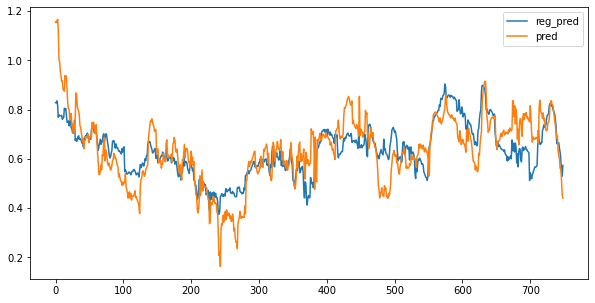

[-5.59324399e-02 -2.47857735e-02 -5.55111512e-17 -6.35594653e-02
 -4.02560242e-02 -4.42495827e-02 -6.01114466e-02]
0.6558789991173227


In [61]:
y_pred_1 = model_1.predict(X_1)

plt.figure(figsize=(10,5))
plt.plot(np.array(y_pred_1),label = "reg_pred")
plt.plot(np.array(y_1),label = "pred")
plt.legend()
plt.show()

coefficients = model_1.coef_
intercept = model_1.intercept_

print(coefficients)
print(intercept)

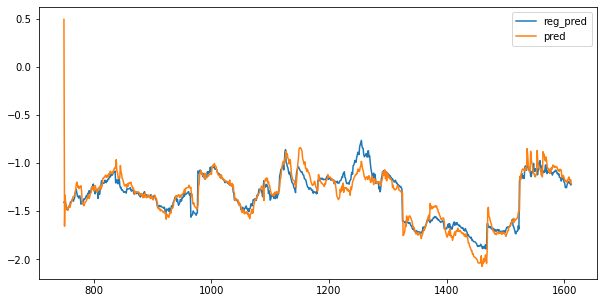

[-7.35055696e-02 -5.82577842e-03  2.08166817e-17 -5.49994431e-02
 -1.34501396e-01  1.13956828e-02  7.45315289e-02]
-1.300302224753242


In [62]:
y_pred_2 = model_2.predict(X_2)

plt.figure(figsize=(10,5))
x_values = np.arange(749, 1613) 
plt.plot(x_values, np.array(y_pred_2), label="reg_pred")
plt.plot(x_values, np.array(y_2), label="pred")
plt.legend()
plt.show()

coefficients = model_2.coef_
intercept = model_2.intercept_

print(coefficients)
print(intercept)

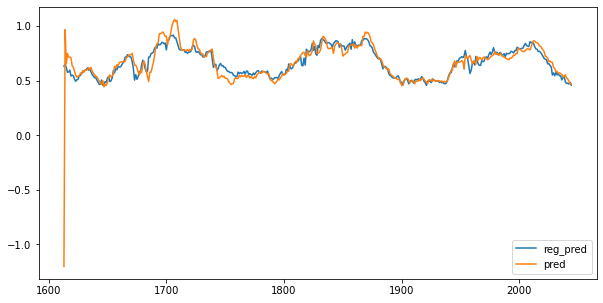

[-9.21227971e-02  1.03293745e-01 -8.32667268e-17 -3.17582146e-02
 -8.50628046e-02 -2.88255154e-02 -2.70310877e-02]
0.6790901919108749


In [63]:
y_pred_3 = model_3.predict(X_3)

plt.figure(figsize=(10,5))
x_values = np.arange(1613, 2045) 
plt.plot(x_values, np.array(y_pred_3), label="reg_pred")
plt.plot(x_values, np.array(y_3), label="pred")
plt.legend()
plt.show()

coefficients = model_3.coef_
intercept = model_3.intercept_

print(coefficients)
print(intercept)

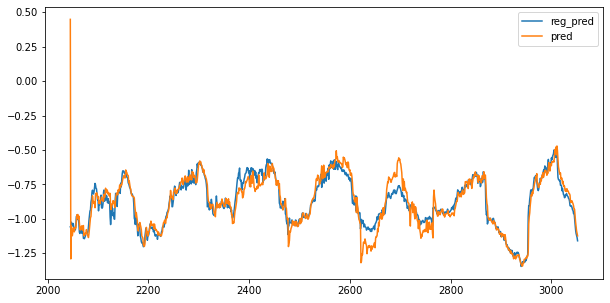

[-8.18248651e-02  5.47583222e-02 -1.17961196e-16 -6.63295911e-02
 -1.43088710e-01 -1.01261223e-02  5.31776915e-02]
-0.8515466508968312


In [64]:
y_pred_4 = model_4.predict(X_4)

plt.figure(figsize=(10,5))
x_values = np.arange(2045, 3053) 
plt.plot(x_values, np.array(y_pred_4), label="reg_pred")
plt.plot(x_values, np.array(y_4), label="pred")
plt.legend()
plt.show()

coefficients = model_4.coef_
intercept = model_4.intercept_

print(coefficients)
print(intercept)

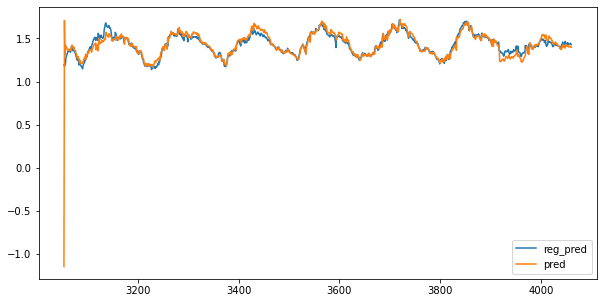

[-8.27590284e-02  4.19745080e-02 -8.23993651e-18 -5.05192142e-02
 -5.85458275e-02 -3.48699319e-02  3.94414835e-02]
1.4078928683983236


In [65]:
y_pred_5 = model_5.predict(X_5)

plt.figure(figsize=(10,5))
x_values = np.arange(3053, 4061) 
plt.plot(x_values, np.array(y_pred_5), label="reg_pred")
plt.plot(x_values, np.array(y_5), label="pred")
plt.legend()
plt.show()

coefficients = model_5.coef_
intercept = model_5.intercept_

print(coefficients)
print(intercept)

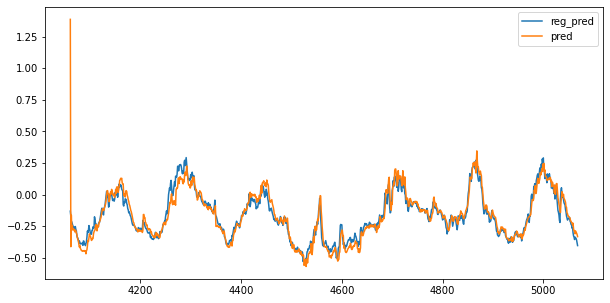

[-7.91550368e-02 -1.10659930e-02 -8.02309608e-17 -1.01156506e-01
 -2.08575831e-01 -1.66183605e-02  6.44548141e-02]
-0.06290451236093611


In [66]:
y_pred_6 = model_6.predict(X_6)

plt.figure(figsize=(10,5))
x_values = np.arange(4061, 5069) 
plt.plot(x_values, np.array(y_pred_6), label="reg_pred")
plt.plot(x_values, np.array(y_6), label="pred")
plt.legend()
plt.show()

coefficients = model_6.coef_
intercept = model_6.intercept_

print(coefficients)
print(intercept)